In [45]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [58]:
df = df_dow.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD'])]
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 6


In [59]:
# add covariance matrix as states
df=cleaned_data.copy().sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [61]:
import pickle 
  
with open('./data/dow_with_cov.pkl', 'wb') as file: 
    pickle.dump(df, file) 

In [ ]:
with open('./data/dow_with_cov.pkl', 'rb') as file: 
    df = pickle.load(file)

In [62]:
cleaned_data = df.copy()

In [63]:
cleaned_data['std_return_60'] = cleaned_data.groupby('tic')['log_return'].ewm(span=60,ignore_na=False,
            min_periods=1).std().reset_index(level=0,drop=True)
cleaned_data['std_return_21'] = cleaned_data.groupby('tic')['log_return'].ewm(span=21,ignore_na=False,
            min_periods=1).std().reset_index(level=0,drop=True)


cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'].ewm(span=63,ignore_na=False,
            min_periods=1).std().reset_index(level=0,drop=True)

cleaned_data['macd_normalized'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63'] 

cleaned_data['rsi'] = cleaned_data['rsi_30'] /100



In [64]:

train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 6


In [70]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            weights = self.softmax_normalization(actions) 
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            log_portfolio_return = np.log(sum((self.data.close.values / last_day_memory.close.values)*weights))
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = log_portfolio_return
            

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [72]:
stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
tech_indicator_list = ['macd', 'macd_normalized']
feature_dimension = len(tech_indicator_list)
print(f"Feature Dimension: {feature_dimension}")
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1
}

e_train_gym = StockPortfolioEnv(df = train_data, **env_kwargs)

Stock Dimension: 6, State Space: 6
Feature Dimension: 2


In [73]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [74]:
from models import DRLAgent


agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 10, "ent_coef": 0.005, "learning_rate": 0.0004}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS,tensorboard_log="./tensorboard_log/" + 'a2c',)

{'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Using cuda device


In [76]:
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
save_callback = CheckpointCallback(
    save_freq=10000,
    save_path="./data/a2c3",
    name_prefix='test_model',
)
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward",
                               value=self.locals["rewards"][0])

        except BaseException as error:
            try:
                self.logger.record(key="train/reward",
                                   value=self.locals["reward"][0])

            except BaseException as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
                # Print the original error and the inner error for debugging
                print("Original Error:", error)
                print("Inner Error:", inner_error)
        return True

model = model_a2c.learn(
    total_timesteps=100_000,
    tb_log_name='zac',
    callback=[TensorboardCallback()],
)

Logging to ./tensorboard_log/a2c\zac_3
----------------------------------------
| time/                 |              |
|    fps                | 82           |
|    iterations         | 100          |
|    time_elapsed       | 12           |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       | -8.57        |
|    explained_variance | -17.9        |
|    learning_rate      | 0.0004       |
|    n_updates          | 99           |
|    policy_loss        | -0.591       |
|    reward             | -0.022737008 |
|    std                | 1.01         |
|    value_loss         | 0.0103       |
----------------------------------------
begin_total_asset:1000000
end_total_asset:1773281.4351718351
Sharpe:  0.8778314236927242
-----------------------------------------
| time/                 |               |
|    fps                | 80            |
|    iterations         | 200           |
|    time_elapsed       | 24            |
|    t

In [77]:
e_trade_gym = StockPortfolioEnv(df = test_data, **env_kwargs)
df_daily_return_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=model,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1124866.6008862064
Sharpe:  0.3979043071090241
hit end!


In [78]:
df_daily_return_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=model,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1124866.6008862064
Sharpe:  0.3979043071090241
hit end!


In [79]:
def extract_weights(drl_actions_list):
  a2c_weight_df = {'date':[], 'weights':[]}
  for i in range(len(drl_actions_list)):
    date = drl_actions_list.index[i]
    tic_list = list(drl_actions_list.columns)
    weights_list = drl_actions_list.reset_index()[list(drl_actions_list.columns)].iloc[i].values
    weight_dict = {'tic':[], 'weight':[]}
    for j in range(len(tic_list)):
      weight_dict['tic'] += [tic_list[j]]
      weight_dict['weight'] += [weights_list[j]]

    a2c_weight_df['date'] += [date]
    a2c_weight_df['weights'] += [pd.DataFrame(weight_dict)]

  a2c_weights = pd.DataFrame(a2c_weight_df)
  return a2c_weights

a2c_weights = extract_weights(df_actions_a2c)

<Figure size 1000x500 with 0 Axes>

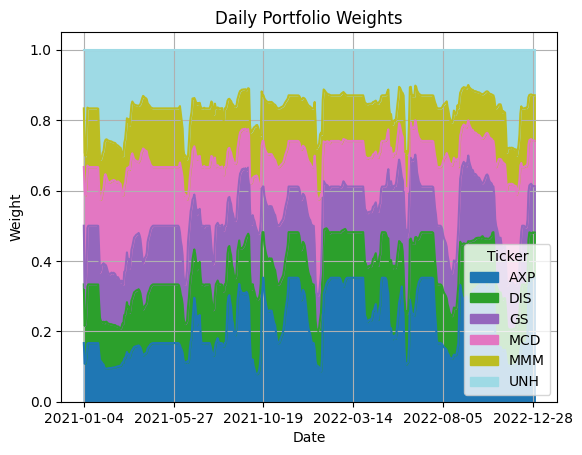

In [80]:
%matplotlib inline

expanded_weights = []
for i, row in a2c_weights.iterrows():
    temp_df = row['weights'].copy()
    temp_df['date'] = row['date']  # Add the date column
    expanded_weights.append(temp_df)

# Combine into one DataFrame
weights_df = pd.concat(expanded_weights)

# Pivot the table for plotting
weights_pivot = weights_df.pivot(index='date', columns='tic', values='weight')

# Plot
plt.figure(figsize=(10, 5))
weights_pivot.plot(kind='area', colormap='tab20')

plt.title('Daily Portfolio Weights')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(title='Ticker')
plt.grid(True)
plt.show()

In [ ]:
%matplotlib inline

expanded_weights = []
for i, row in a2c_weights.iterrows():
    temp_df = row['weights'].copy()
    temp_df['date'] = row['date']  # Add the date column
    expanded_weights.append(temp_df)

# Combine into one DataFrame
weights_df = pd.concat(expanded_weights)

# Pivot the table for plotting
weights_pivot = weights_df.pivot(index='date', columns='tic', values='weight')

# Plot
plt.figure(figsize=(10, 5))
weights_pivot.plot(kind='area', colormap='tab20')

plt.title('Daily Portfolio Weights')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(title='Ticker')
plt.grid(True)
plt.show()

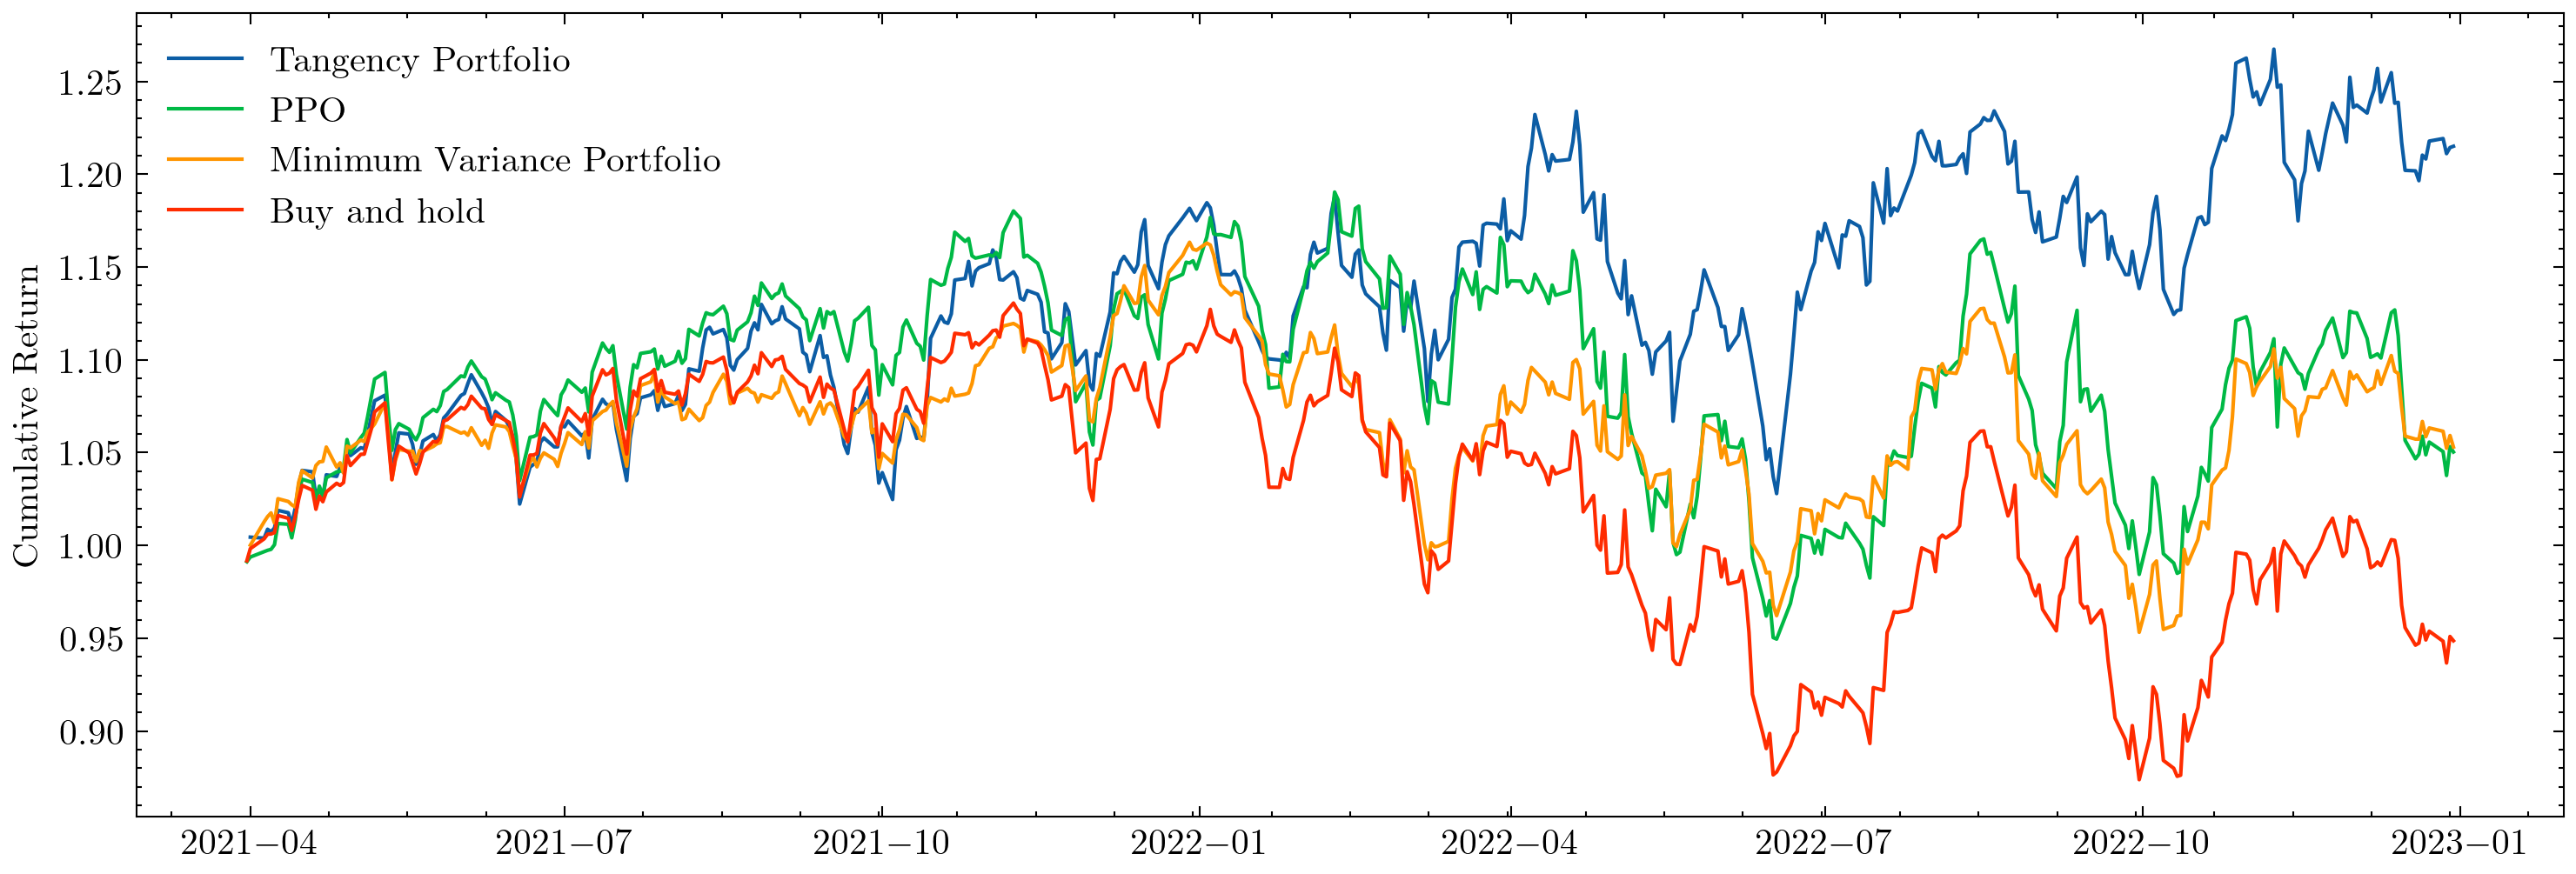

In [42]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_lstm_test_result[0].get('date'),(ppo_lstm_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [87]:
import quantstats as qs

In [213]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(0.3388092143131057),
 'max_drow_down': np.float64(-0.2664428956423516),
 'var': -0.02301269977821848,
 'return': np.float64(0.09390949999999965)}

In [214]:
mvo_min_returns = min_variacen_portfolio['test'][['date','total_assets']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['total_assets']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['total_assets']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['total_assets'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(0.2633164866290335),
 'max_drow_down': np.float64(-0.18063587669076375),
 'var': -0.01639642306661718,
 'return': np.float64(0.05302095955995423)}

In [215]:

mvo_sharpe_returns = result_sharpe['test'][['date','total_assets']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['total_assets'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.666227580986604),
 'max_drow_down': np.float64(-0.16693110888675866),
 'var': -0.019609587852893476,
 'return': np.float64(0.21507314715763637)}

In [216]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(-0.06122215468658751),
 'max_drow_down': np.float64(-0.22713166127519646),
 'var': -0.019835048058484694,
 'return': np.float64(-0.051356343491552825)}

In [217]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats]

In [218]:
stats_df = pd.DataFrame(stats)

In [219]:
stats_df

,name,sharpe_ratio,max_drow_down,var,return
0,Buy and Hold,-0.061222,-0.227132,-0.019835,-0.051356
1,Tangency Portfolio,0.666228,-0.166931,-0.019610,0.215073
2,Min variance portfolio,0.263316,-0.180636,-0.016396,0.053021
3,Proximal Policy Optimization,0.338809,-0.266443,-0.023013,0.093909


In [220]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())